In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
import numpy as np
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)



class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(3072, 1500)  # 第一层
        self.fc2 = nn.Linear(1500, 750)   # 第二层
        self.fc3 = nn.Linear(750, 375)    # 第三层，编码到375维

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(375, 750)    # 第一层
        self.fc2 = nn.Linear(750, 1500)   # 第二层
        self.fc3 = nn.Linear(1500, 3072)  # 第三层，解码回3072维

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [2]:
# 设置
batch_size = 64
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
root = '../datasets'

# 数据预处理，包括转换为Tensor和展平
transform = transforms.Compose([
    transforms.ToTensor(),                   # 将图像转换为Tensor
    transforms.Lambda(lambda x: torch.flatten(x))  # 展平图像
])

# 加载CIFAR-10数据集
train_dataset = datasets.CIFAR10(root, train=True, transform=transform, download=True)

# 创建数据加载器
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)

# 实例化模型
encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=learning_rate)

# 训练模型
num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()
        en_outputs = encoder(inputs)
        de_outputs = decoder(en_outputs)
        loss = criterion(de_outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

Using cuda device
Files already downloaded and verified
Epoch [1/30], Average Loss: 0.0637
Epoch [2/30], Average Loss: 0.0374
Epoch [3/30], Average Loss: 0.0285
Epoch [4/30], Average Loss: 0.0254
Epoch [5/30], Average Loss: 0.0225
Epoch [6/30], Average Loss: 0.0213
Epoch [7/30], Average Loss: 0.0197
Epoch [8/30], Average Loss: 0.0186
Epoch [9/30], Average Loss: 0.0178
Epoch [10/30], Average Loss: 0.0172
Epoch [11/30], Average Loss: 0.0168
Epoch [12/30], Average Loss: 0.0164
Epoch [13/30], Average Loss: 0.0163
Epoch [14/30], Average Loss: 0.0160
Epoch [15/30], Average Loss: 0.0157
Epoch [16/30], Average Loss: 0.0155
Epoch [17/30], Average Loss: 0.0153
Epoch [18/30], Average Loss: 0.0151
Epoch [19/30], Average Loss: 0.0151
Epoch [20/30], Average Loss: 0.0149
Epoch [21/30], Average Loss: 0.0147
Epoch [22/30], Average Loss: 0.0144
Epoch [23/30], Average Loss: 0.0142
Epoch [24/30], Average Loss: 0.0142
Epoch [25/30], Average Loss: 0.0141
Epoch [26/30], Average Loss: 0.0141
Epoch [27/30], Av

In [3]:
# 创建保存模型的目录（如果它还不存在）
model_dir = '../model/mse_cifar'
os.makedirs(model_dir, exist_ok=True)

# 保存模型状态字典
torch.save(encoder.state_dict(), os.path.join(model_dir, 'encoder.pth'))
torch.save(decoder.state_dict(), os.path.join(model_dir, 'decoder.pth'))


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


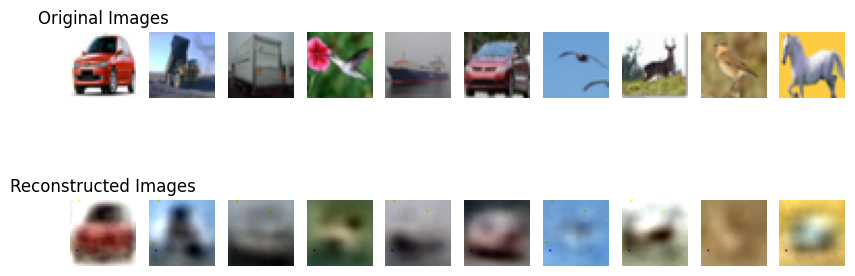

In [6]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 实例化并加载模型
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model_dir = '../model/mse_cifar'

encoder.load_state_dict(torch.load(os.path.join(model_dir, 'encoder.pth'), map_location=device))
decoder.load_state_dict(torch.load(os.path.join(model_dir, 'decoder.pth'), map_location=device))

# 将模型设置为评估模式
encoder.eval()
decoder.eval()

# 加载 CIFAR-10 测试数据集
test_dataset = datasets.CIFAR10(root='../datasets', train=False, 
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Lambda(lambda x: torch.flatten(x))
                                 ]), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)

# 从数据加载器中获取一批数据
data_iter = iter(test_loader)
images, _ = next(data_iter)

# 将图像移动到设备上
images = images.to(device)

# 使用编码器和解码器
with torch.no_grad():
    encoded_imgs = encoder(images)
    decoded_imgs = decoder(encoded_imgs)

# 将图像移动回CPU，并调整形状以适应 CIFAR-10 的图像尺寸
images = images.cpu()
decoded_imgs = decoded_imgs.view(-1, 3, 32, 32).cpu()

# 绘制原始图像和重建图像
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 4))
for i in range(10):
    # 显示原始图像
    ax = axes[0, i]
    ax.imshow(images[i].view(3, 32, 32).permute(1, 2, 0))
    ax.axis('off')

    # 显示重建图像
    ax = axes[1, i]
    ax.imshow(decoded_imgs[i].permute(1, 2, 0))
    ax.axis('off')

axes[0, 0].set_title('Original Images')
axes[1, 0].set_title('Reconstructed Images')
plt.show()